Вы работаете в интернет-магазине, который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Общая информация

Установим библиотеку для работы с пропусками missingno

In [117]:

import sys
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install missingno


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from pymystem3 import Mystem
from collections import Counter
from scipy import stats as st
pd.set_option('display.float_format', '{:,.2f}'.format)

In [119]:
df = pd.read_csv('/datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,"2,006.00",Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,"1,985.00",Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.00",Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,"2,009.00",Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.00",Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [121]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

## Предобработка данных

Приведем название столбцов к нижнему регистру

In [122]:
df.columns = df.columns.str.lower()
features = list(df.columns)

Преобразуем данные в нужные типы

In [123]:
df['year_of_release'] = df['year_of_release'].astype('int', errors='ignore')

TBD в столбце user_score - to be determind (подлежит уточнению) перенесем этот признак в отдельный булев столбец

In [124]:
df['tbd'] = df['user_score'].where(df['user_score'] == 'tbd', 0)

In [125]:
df['tbd'] = df['tbd'].where(df['tbd'] == 0, 1)

In [126]:
df['tbd'] = df['tbd'].astype('bool')

In [127]:
df['user_score'] = df['user_score'].where(df['user_score'] != 'tbd', np.nan)

Переведем user_score в числовой тип

In [128]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='ignore')

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
tbd                16715 non-null bool
dtypes: bool(1), float64(7), object(4)
memory usage: 1.4+ MB


Обработка пропусков

In [130]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
tbd                   0
dtype: int64

Выведим диаграмму которая показывает заполнение столбцов

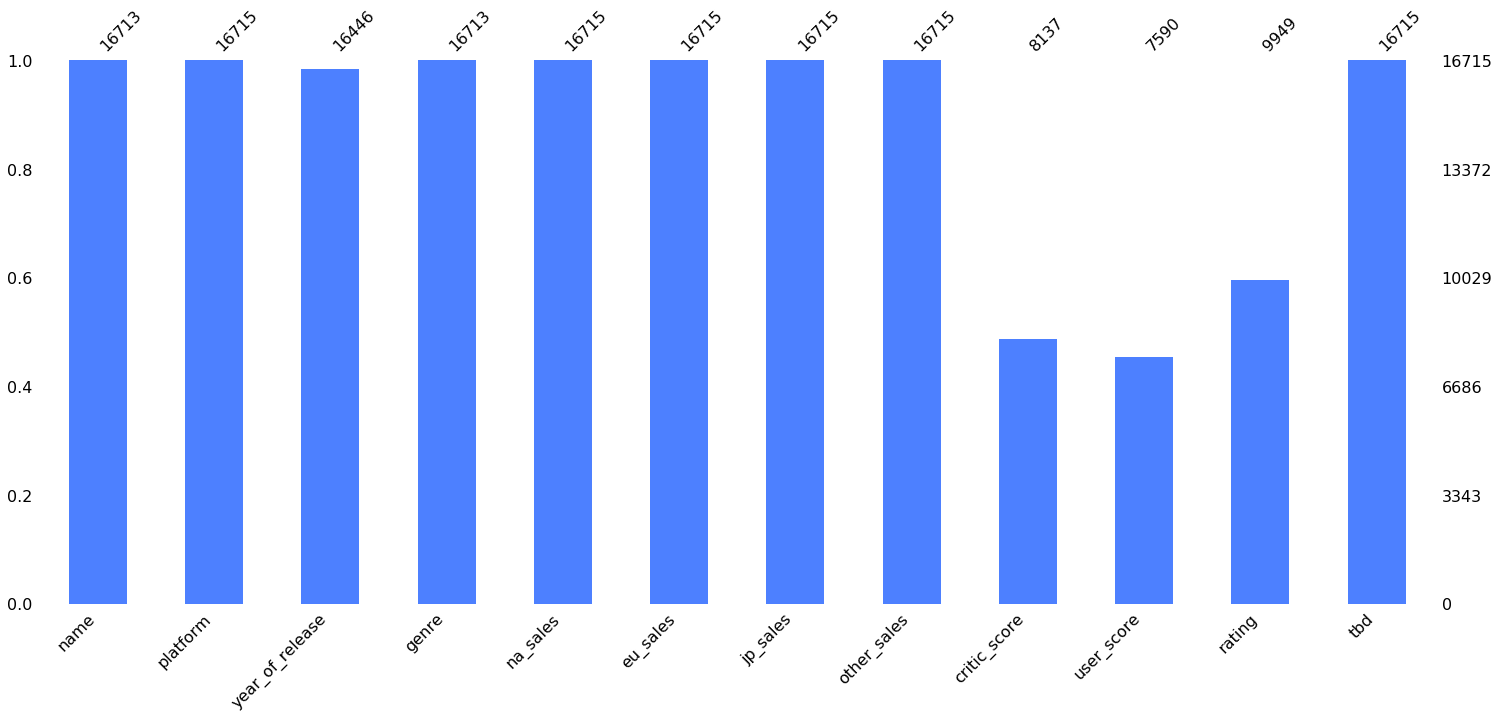

In [131]:
msno.bar(df, labels=True, color=(0.3,0.5,1))

Визуализация пропусков столбцов

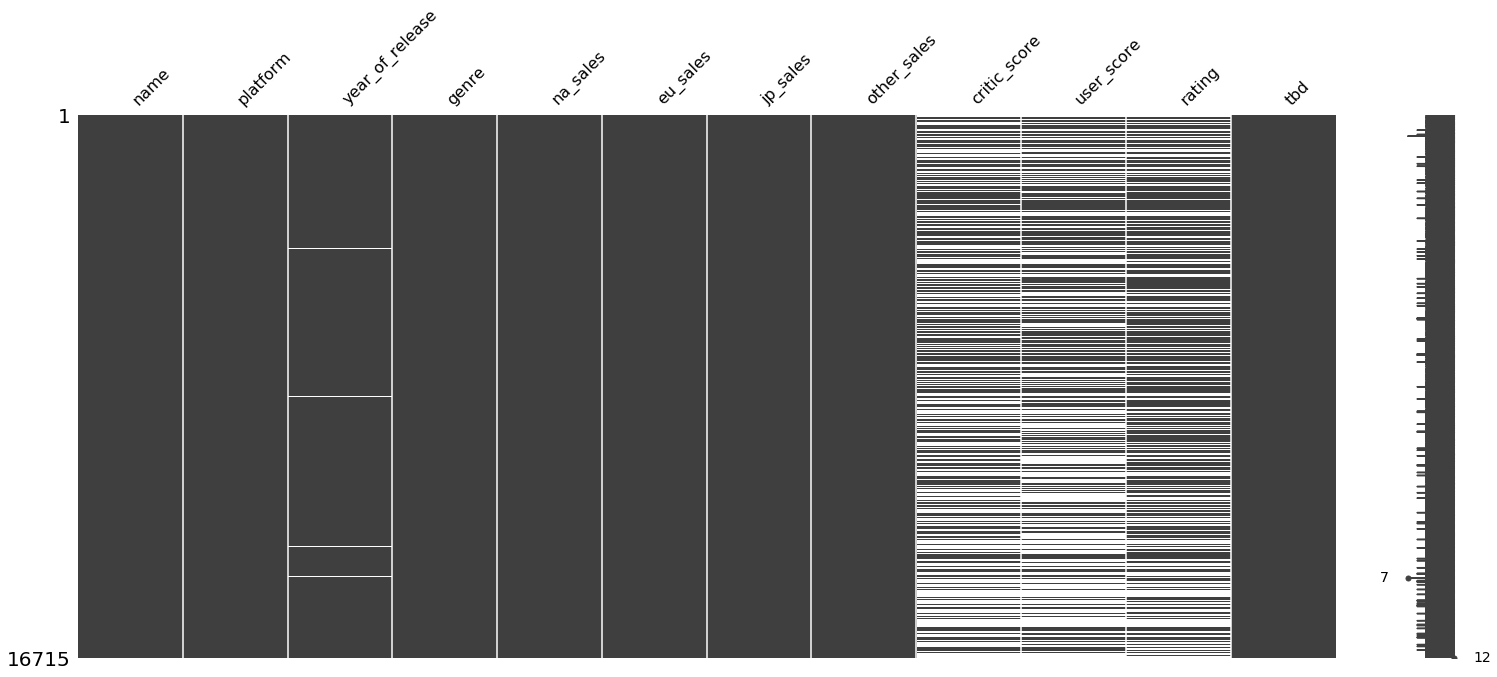

In [132]:
msno.matrix(df)

Отсортируем для наглядности

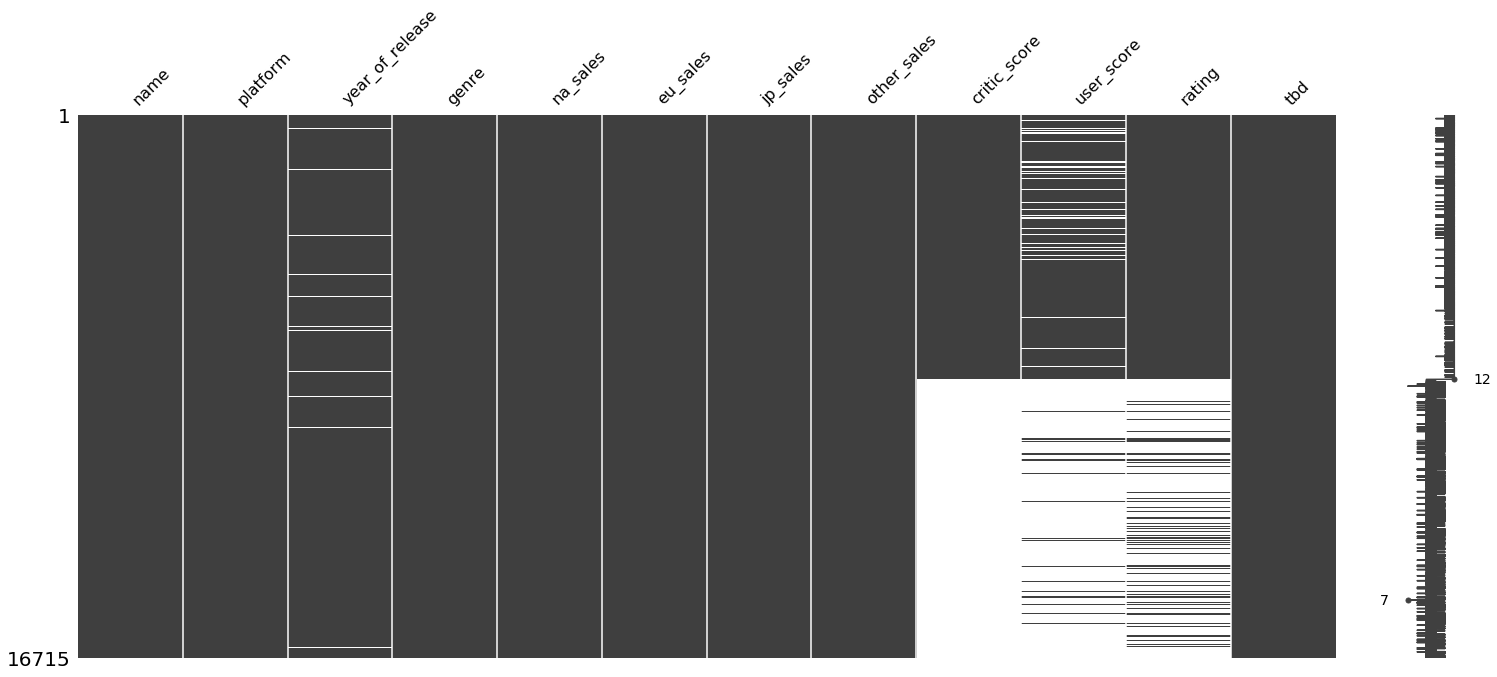

In [133]:
msno.matrix(df.sort_values('critic_score'))

Выведим только столбцы с пропусками

In [134]:
features_with_na = [feature for feature in df.columns if df[feature].isnull().sum() > 1]

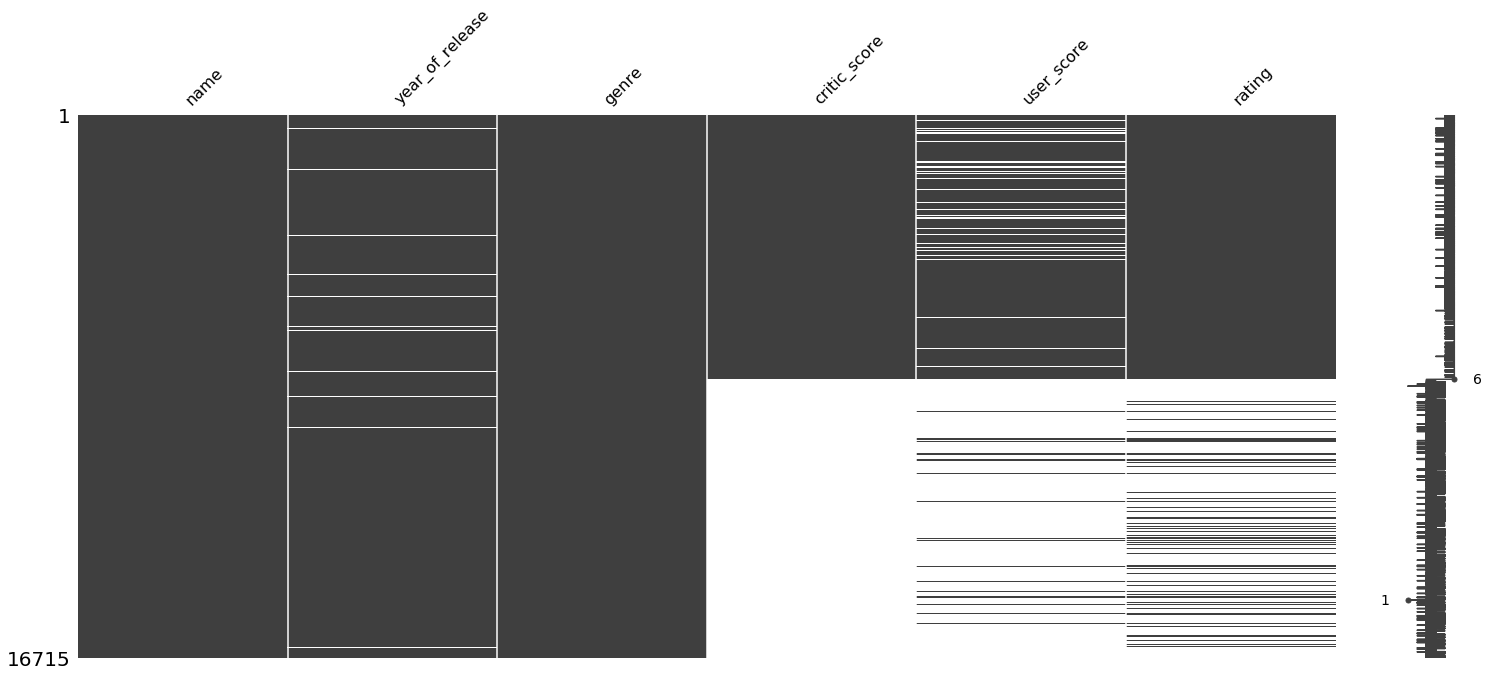

In [135]:
msno.matrix(df[features_with_na].sort_values('critic_score'))

Рассмотрим взяимосвяь пропусков

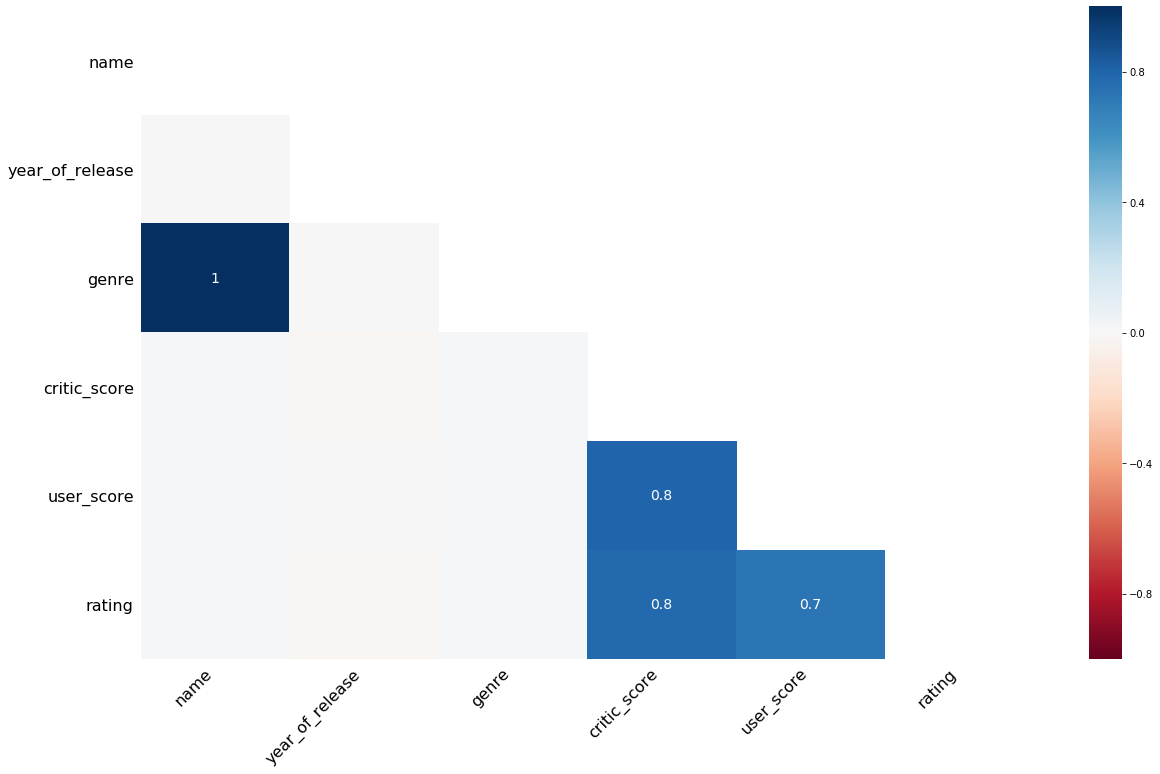

In [136]:
msno.heatmap(df[features_with_na])

Видно, что строки с пропусками в признаках user_score и rating совпадают почти полностью.

Две строки с пропусками в признаках name и genre совпадают почти полностью, их немного и можно удалить

In [137]:
df = df[~df['name'].isna()]
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'tbd'],
      dtype='object')

Часть пропусков в critic_score, user_score можно заполнить средними оценками по разным платформам игры

Text(0, 0.5, 'frequency')

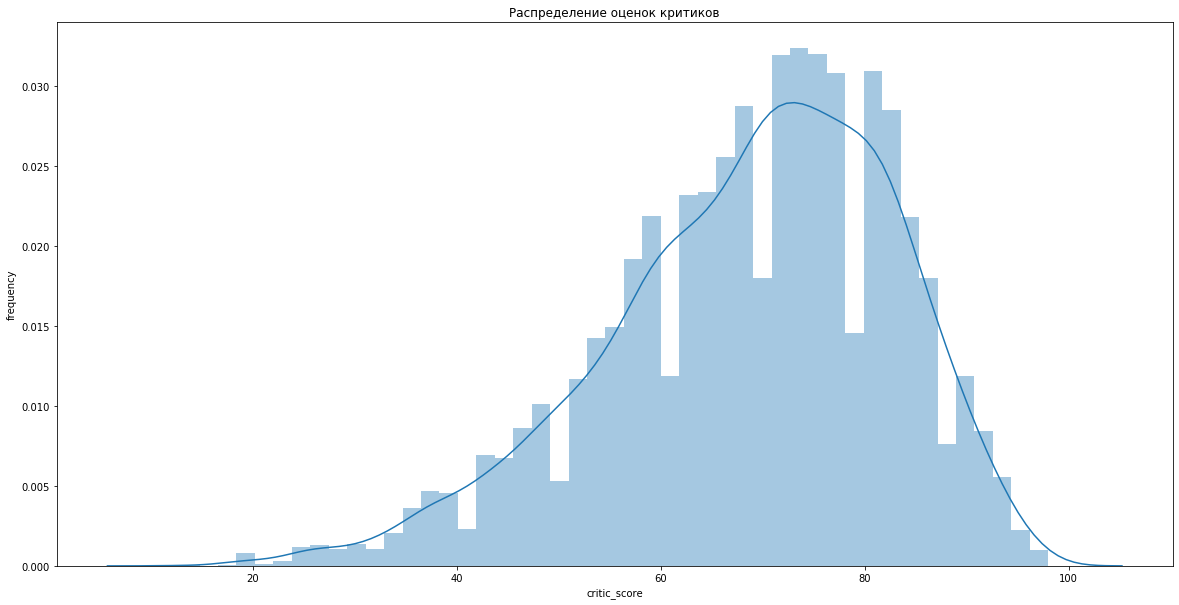

In [178]:
sns.distplot(df[~df['critic_score'].isna()]['critic_score'])
plt.title('Распределение оценок критиков')
plt.ylabel('frequency')

In [139]:
df['critic_score'] = df['critic_score'].fillna(
    df.groupby(
        'name')['critic_score'].transform(
        'mean'))

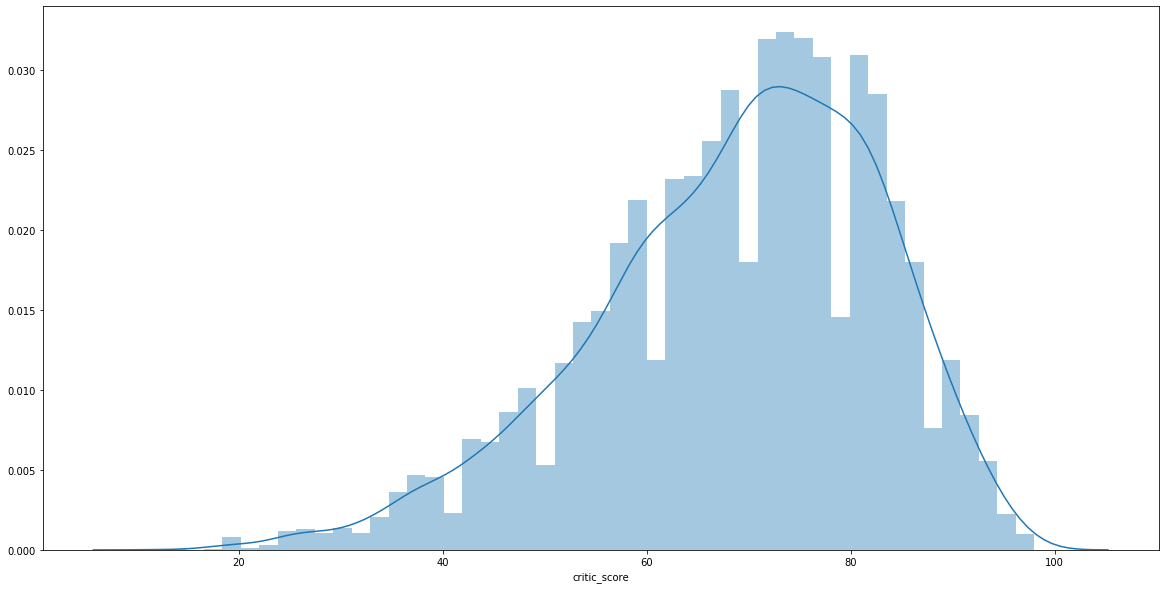

In [140]:
sns.distplot(df[~df['critic_score'].isna()]['critic_score'])
plt.title('Распределение оценок критиков после частичного заполнения')
plt.ylabel('frequency')

In [141]:
df['user_score'] = df['user_score'].fillna(
    df.groupby(
        'name')['user_score'].transform(
        'mean'))

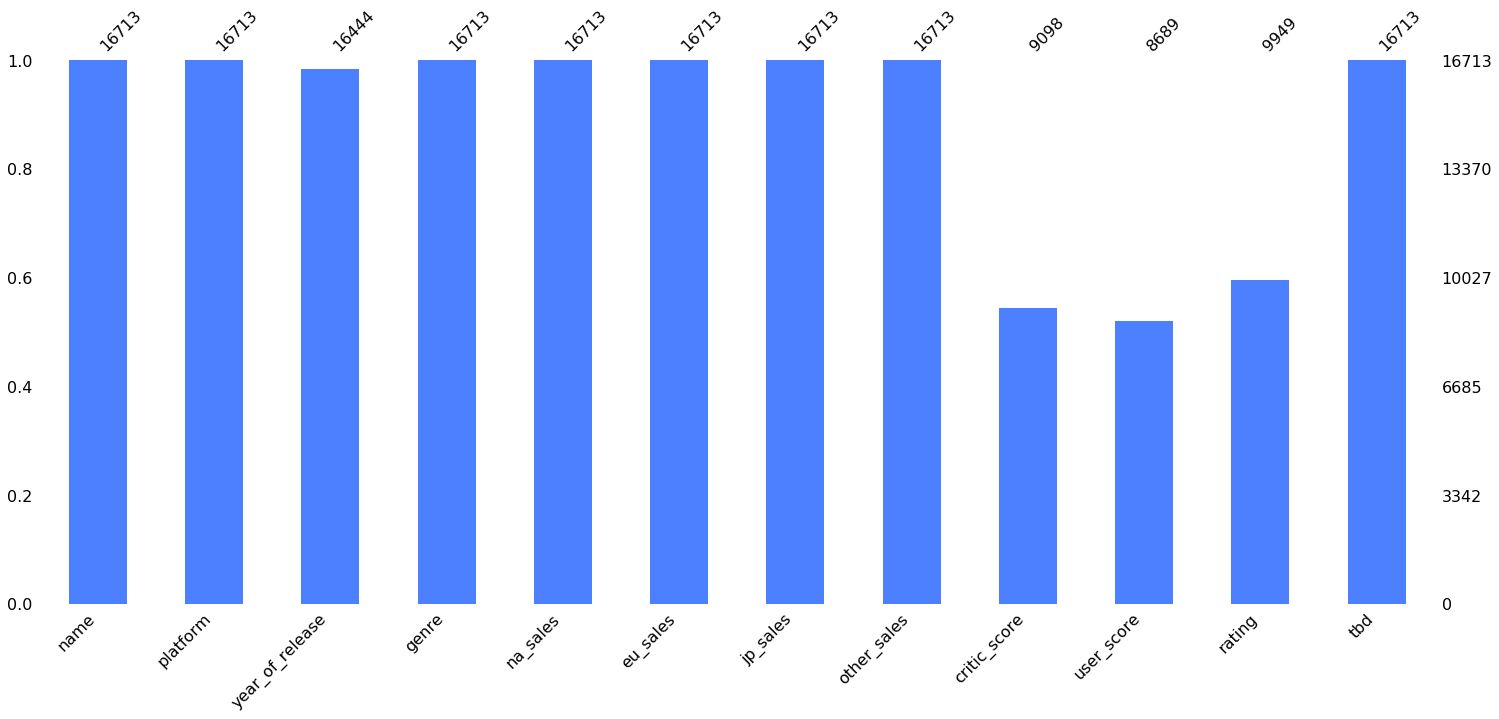

In [142]:
msno.bar(df, labels=True, color=(0.3,0.5,1))

Оставшиеся пропуски в столбцах critic_score, user_score, rating заполнять не будем, их около 50% и любое заполнение повлияет на результат исследования. Если заполнить средним, то это наоборот не повлияет на проверку гипотез в конце исследования, тк как усилит распределение вокруг средних значений.

Посчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец

In [143]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

## Предварительный анализ данных

Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды

Text(0.5, 1.0, 'Сколько игр выпускалось в разные годы')

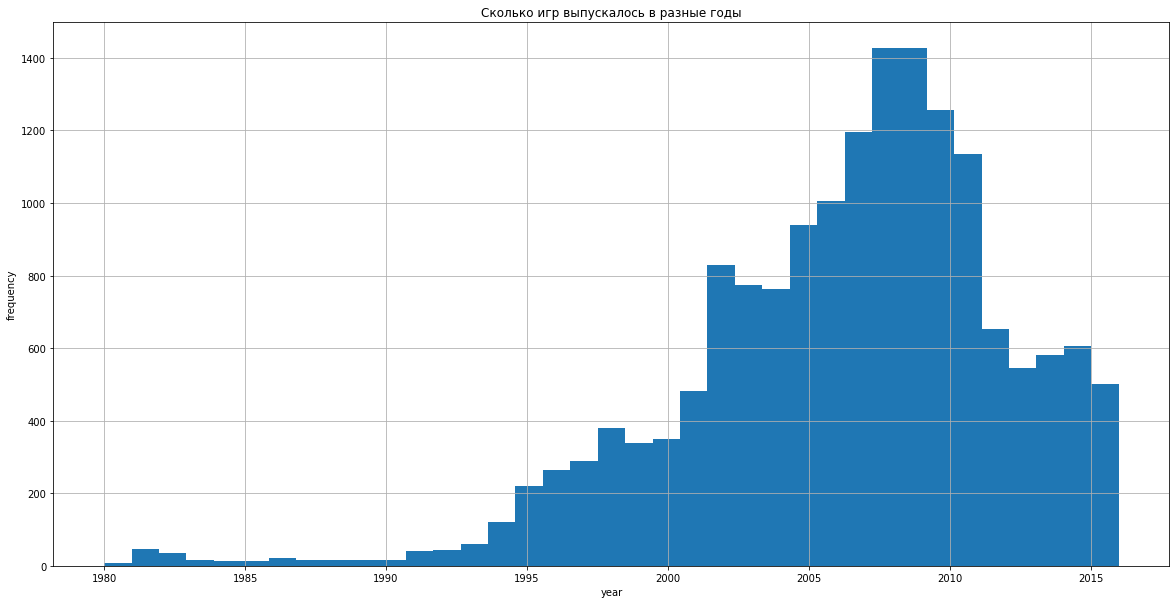

In [144]:
(df[~df['year_of_release'].isna()]['year_of_release']).hist(bins=37)
plt.xlabel('year')
plt.ylabel('frequency')
plt.title('Сколько игр выпускалось в разные годы')

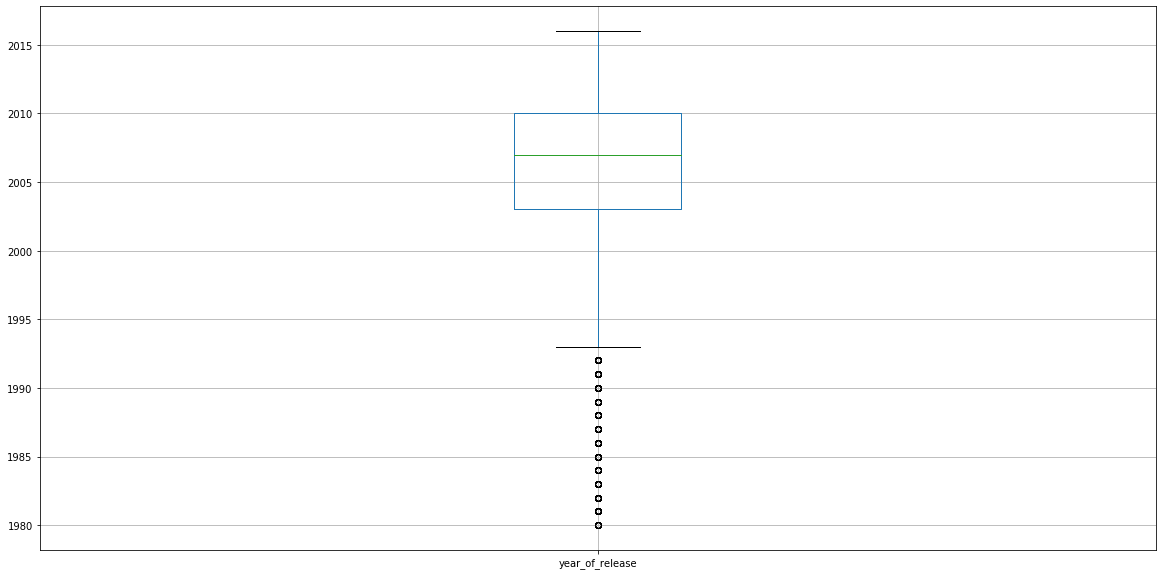

In [145]:
df.boxplot('year_of_release')

In [146]:
df['year_of_release'].describe()

count   16,444.00
mean     2,006.49
std          5.88
min      1,980.00
25%      2,003.00
50%      2,007.00
75%      2,010.00
max      2,016.00
Name: year_of_release, dtype: float64

Медианное и среднее значения года выпуска игр ~ 2007 год. Данные об играх выпущенные раньше 25% квартиля - 2003 года не важны и не репрезентативны, отсечем их.

Text(0, 0.5, 'sales')

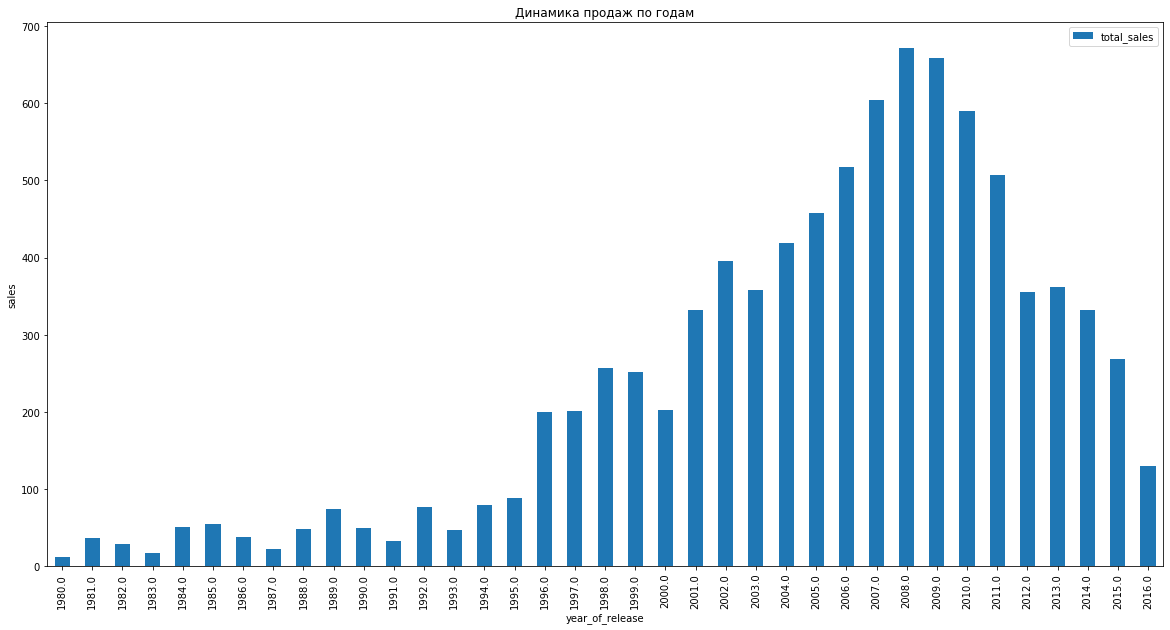

In [147]:
df[['total_sales', 'year_of_release']].groupby('year_of_release').sum().plot(kind='bar')
plt.title('Динамика продаж по годам')
plt.ylabel('sales')

Посмотрим, как менялись продажи по платформам с 2003 года

In [148]:
df_platforms = df.query('year_of_release > 2003')

Выберим платформы с наибольшими суммарными продажами и построим распределение по годам

In [149]:
(df_platforms.groupby('platform')['total_sales']
 .sum()
 .sort_values(ascending=False)
 .head(10))

platform
X360   961.24
PS3    931.34
Wii    891.18
DS     802.76
PS2    638.27
PS4    314.14
PSP    289.53
3DS    257.81
PC     178.18
XOne   159.32
Name: total_sales, dtype: float64

In [150]:
best_platforms = list(df_platforms
                      .groupby('platform')['total_sales']
                      .sum()
                      .sort_values(ascending=False)
                      .head(6)
                      .index[0:6])

Выведим список с лучшими по продажам игр с 2003 года платформы:

In [151]:
best_platforms

['X360', 'PS3', 'Wii', 'DS', 'PS2', 'PS4']

In [152]:
df_platforms_best = df_platforms[df_platforms['platform'].isin(best_platforms)]

In [153]:
df_platforms_best = pd.pivot_table(
    df_platforms_best,
    values='total_sales', 
    index=['platform','year_of_release'], 
    aggfunc=np.sum).reset_index()

Построим график продаж по лучшим платформам по годам

Text(0.5, 1.0, 'Продажи y/y по платформам')

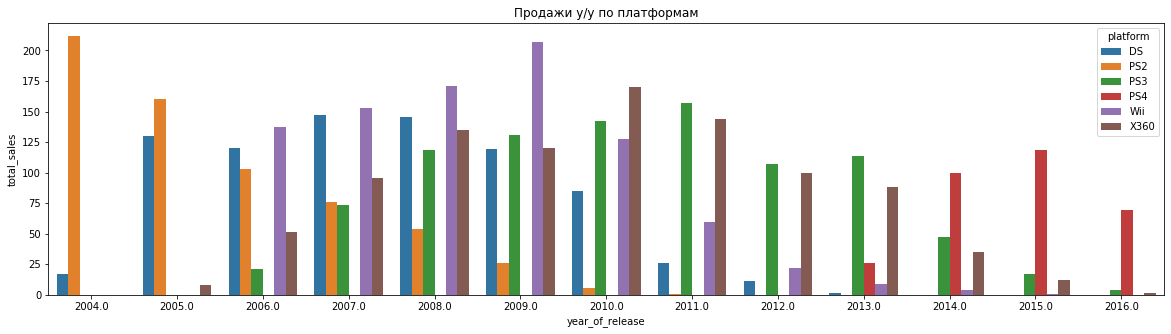

In [154]:
plt.rcParams["figure.figsize"] = (20,5)
sns.barplot(data=df_platforms_best,x='year_of_release',y='total_sales', hue='platform')
plt.title('Продажи y/y по платформам')

9-10 лет характерный срок за который появляются новые и исчезают старые платформы, это и будет нашим актуальным периодом для прогнозирования продаж в 2017 году

2007-2016

Определим какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.

In [155]:
df_platforms_actual = df.query('year_of_release > 2007')
df_platforms_actual['total_sales']

2       35.52
3       32.77
8       28.32
14      21.82
15      21.80
         ... 
16707    0.01
16709    0.00
16710    0.01
16712    0.01
16714    0.01
Name: total_sales, Length: 8130, dtype: float64

Text(0.5, 1.0, 'Продажи y/y по платформам')

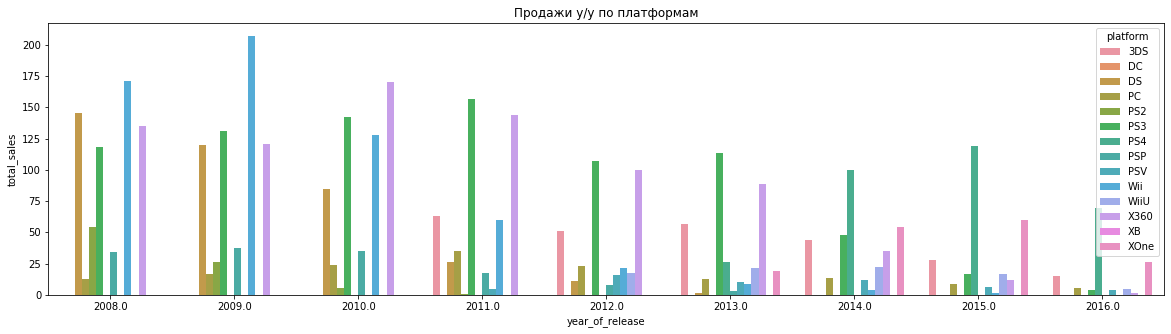

In [156]:
df_platforms_actual = pd.pivot_table(
    df_platforms_actual,
    values='total_sales', 
    index=['platform','year_of_release'], 
    aggfunc=np.sum).reset_index()
df_platforms_actual.head()
sns.barplot(data=df_platforms_actual,x='year_of_release',y='total_sales', hue='platform')
plt.title('Продажи y/y по платформам')

Список актуальных платформ по убыванию

In [157]:
df_platforms_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS3    837.19
X360   805.96
Wii    601.26
DS     388.60
PS4    314.14
3DS    257.81
XOne   159.32
PC     151.29
PSP    136.38
PS2     86.39
WiiU    82.19
PSV     53.81
XB       0.18
DC       0.04
Name: total_sales, dtype: float64

In [158]:
df_platforms_actual_years = pd.pivot_table(df_platforms_actual,
                                           columns='platform',
                                           values='total_sales',
                                           index='year_of_release').reset_index()

In [159]:
df_platforms_actual_years

platform,year_of_release,3DS,DC,DS,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
0,"2,008.00",nan,0.04,145.31,12.42,53.90,118.52,nan,34.55,nan,171.32,nan,135.26,0.18,nan
1,"2,009.00",nan,nan,119.54,16.91,26.40,130.93,nan,37.78,nan,206.97,nan,120.29,nan,nan
2,"2,010.00",nan,nan,85.02,24.28,5.64,142.17,nan,35.04,nan,127.95,nan,170.03,nan,nan
3,"2,011.00",63.20,nan,26.18,35.03,0.45,156.78,nan,17.82,4.63,59.65,nan,143.84,nan,nan
4,"2,012.00",51.36,nan,11.01,23.22,nan,107.36,nan,7.69,16.19,21.71,17.56,99.74,nan,nan
5,"2,013.00",56.57,nan,1.54,12.38,nan,113.25,25.99,3.14,10.59,8.59,21.65,88.58,nan,18.96
6,"2,014.00",43.76,nan,nan,13.28,nan,47.76,100.00,0.24,11.90,3.75,22.03,34.74,nan,54.07
7,"2,015.00",27.78,nan,nan,8.52,nan,16.82,118.90,0.12,6.25,1.14,16.35,11.96,nan,60.14
8,"2,016.00",15.14,nan,nan,5.25,nan,3.60,69.25,nan,4.25,0.18,4.60,1.52,nan,26.15


Text(0, 0.5, 'sales')

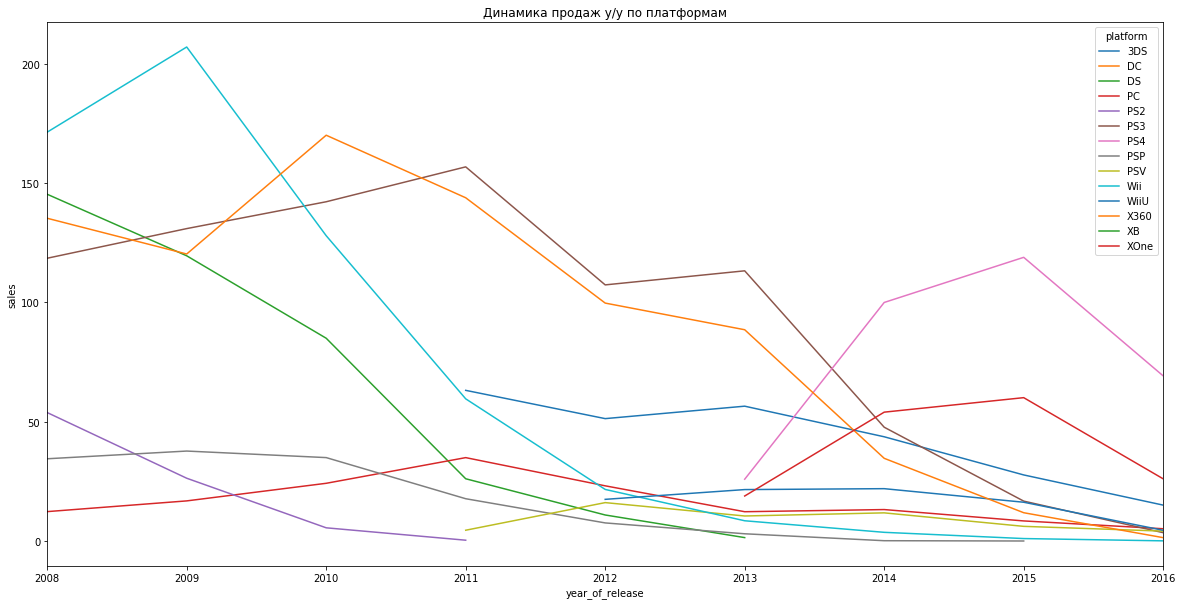

In [160]:
plt.rcParams["figure.figsize"] = (20,10)
df_platforms_actual_years.plot(x='year_of_release')
plt.title('Динамика продаж y/y по платформам')
plt.ylabel('sales')

Посчитаем долевые изменения продаж по годам

In [161]:
plt.rcParams["figure.figsize"] = (20,10)
df_platforms_actual_years = df_platforms_actual_years.set_index('year_of_release')
df_platforms_actual_years.pct_change()

platform,3DS,DC,DS,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,
"2,008.00",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
"2,009.00",nan,0.00,-0.18,0.36,-0.51,0.10,nan,0.09,nan,0.21,nan,-0.11,0.00,nan
"2,010.00",nan,0.00,-0.29,0.44,-0.79,0.09,nan,-0.07,nan,-0.38,nan,0.41,0.00,nan
"2,011.00",nan,0.00,-0.69,0.44,-0.92,0.10,nan,-0.49,nan,-0.53,nan,-0.15,0.00,nan
"2,012.00",-0.19,0.00,-0.58,-0.34,0.00,-0.32,nan,-0.57,2.50,-0.64,nan,-0.31,0.00,nan
"2,013.00",0.10,0.00,-0.86,-0.47,0.00,0.05,nan,-0.59,-0.35,-0.60,0.23,-0.11,0.00,nan
"2,014.00",-0.23,0.00,0.00,0.07,0.00,-0.58,2.85,-0.92,0.12,-0.56,0.02,-0.61,0.00,1.85
"2,015.00",-0.37,0.00,0.00,-0.36,0.00,-0.65,0.19,-0.50,-0.47,-0.70,-0.26,-0.66,0.00,0.11
"2,016.00",-0.46,0.00,0.00,-0.38,0.00,-0.79,-0.42,0.00,-0.32,-0.84,-0.72,-0.87,0.00,-0.57


Продажи по всем платформам падают к 2016 году

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'sales')

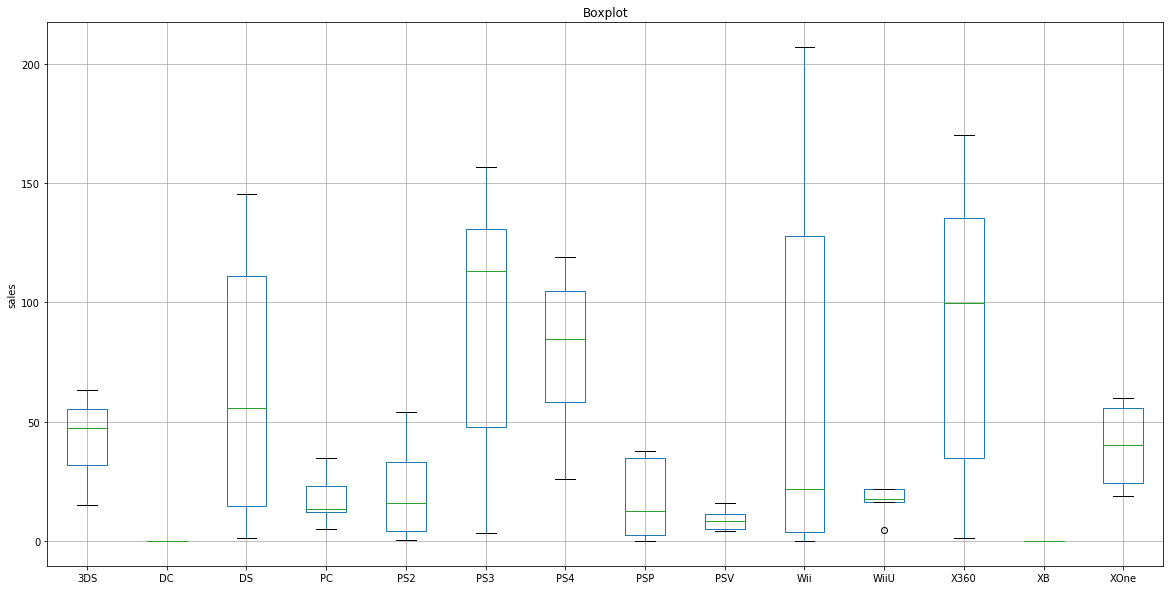

In [162]:
df_platforms_actual_years.boxplot()
plt.title('Boxplot')
plt.ylabel('sales')

Межквартильный размах на самых популярных платформах больше, их продажи по годам имеют большую дисперсию, медиана как правило больше

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами

In [163]:
df_platforms_PS3 = df_platforms[df_platforms['platform']=='PS3']
df_platforms_PS3 = df_platforms_PS3[['name',
                                     'year_of_release',
                                     'critic_score',
                                     'user_score',
                                     'total_sales']]

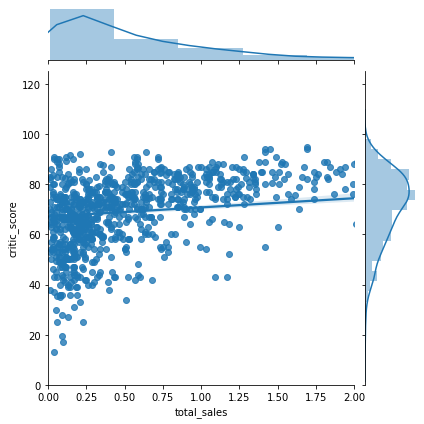

In [164]:
sns.jointplot(x = 'total_sales',
              y = 'critic_score',
              data = df_platforms_PS3,
              kind = 'reg',
              xlim = (0,2),
              ylim = (0,125))

На графике наболюдаем среднюю кореляцию между продажами и оценками критиков

In [165]:
corr = df_platforms_PS3[['critic_score','total_sales','user_score']].corr()
corr

,critic_score,total_sales,user_score
critic_score,1.00,0.41,0.56
total_sales,0.41,1.00,0.13
user_score,0.56,0.13,1.00


In [166]:
corr['total_sales']['critic_score']

0.40681251188940876

Соотнесем выводы с продажами игр на других платформах

In [167]:
df_platforms_scores = df_platforms[['name',
                                    'platform',
                                    'year_of_release',
                                    'critic_score',
                                    'user_score',
                                    'total_sales']]

In [168]:
platforms = list(df_platforms_scores['platform'].unique())

,platform,critic,user
3,PS3,0.41,0.13
8,XB,0.40,0.19
5,PS4,0.39,-0.02
4,PS2,0.39,0.20
2,X360,0.38,0.12
11,XOne,0.37,-0.09
13,GC,0.35,0.27
12,WiiU,0.33,0.37
6,3DS,0.32,0.23
10,PSP,0.30,0.22


Text(0, 0.5, 'corr')

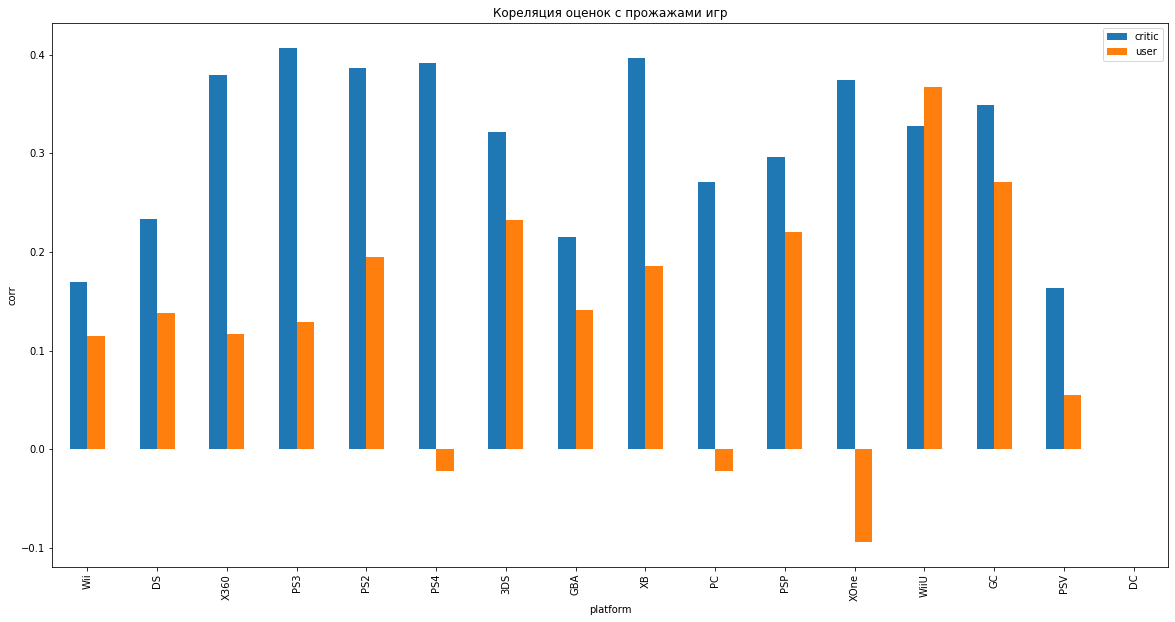

In [169]:
critic=[]
user=[]
platform=[]
for x in platforms:
    corr_df = df_platforms_scores[df_platforms_scores['platform']==x]
    corr_df = corr_df[['critic_score','total_sales','user_score']].corr()
    platform.append(x)
    user.append(corr_df['total_sales']['user_score'])
    critic.append(corr_df['total_sales']['critic_score'])
d = {'platform':platform, 'critic':critic, 'user':user}
corr_df = pd.DataFrame(data=d)
display(corr_df.sort_values('critic', ascending=False))
corr_df.plot.bar(x='platform')
plt.title('Кореляция оценок с прожажами игр')
plt.ylabel('corr')

На менее популярных платформах кореляция ниже

Посмотрим на общее распределение игр по жанрам. Выделяются ли жанры с высокими и низкими продажами?

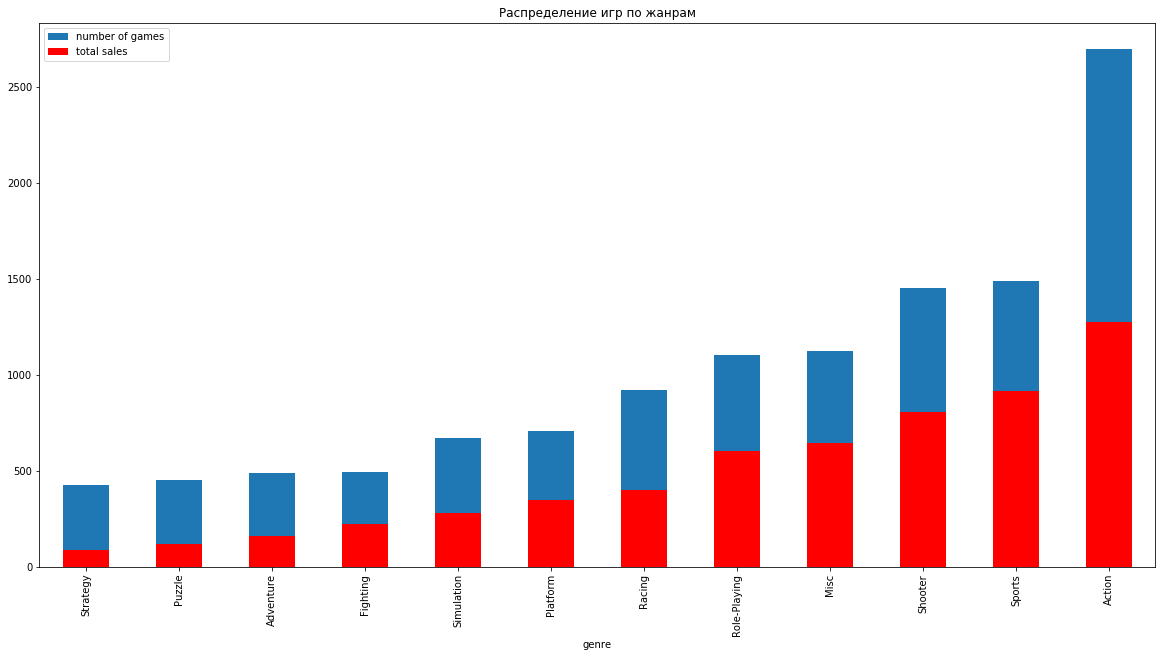

In [170]:
df_platforms.groupby('genre')['name'].count().sort_values().plot.bar()
df_platforms.groupby('genre')['total_sales'].sum().sort_values().plot.bar(color='red')
plt.title('Распределение игр по жанрам')
plt.legend(['number of games', 'total sales'])

Самые прибыльные жанры - Action, Sports, Shooter, они и самые крупные по количеству выпускаемых игр

Выделяются прибыльные жанры в долевом отношении к выпускаемым играм - Role Playing  и Misc.
Action хотя и самый прибыльный, но скорее за счет количества тайтлов.

## Составление портрета пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):

- Самые популярные платформы (топ-5). Опишите различия в долях продаж.

- Самые популярные жанры (топ-5). Поясните разницу.

- Влияние рейтинга ESRB на продажи в отдельном регионе?

In [171]:
focus = ['platform','genre','rating']
for x in focus:
    print('North America')
    display((df_platforms
 .groupby(x)['na_sales']
 .sum()
 .sort_values(ascending=False)
 .head(5)))
    print('Europe')
    display(df_platforms
 .groupby(x)['eu_sales']
 .sum()
 .sort_values(ascending=False)
 .head(5))
    print('Japan')
    display(df_platforms
 .groupby(x)['jp_sales']
 .sum()
 .sort_values(ascending=False)
 .head(5))
    print('-'*50)

North America


platform
X360   595.74
Wii    486.87
PS3    390.13
DS     380.31
PS2    297.27
Name: na_sales, dtype: float64

Europe


platform
PS3    327.21
X360   268.32
Wii    258.32
DS     188.41
PS2    143.15
Name: eu_sales, dtype: float64

Japan


platform
DS    175.00
3DS   100.62
PS3    79.41
PSP    75.88
PS2    70.15
Name: jp_sales, dtype: float64

--------------------------------------------------
North America


genre
Action         619.12
Sports         471.22
Shooter        431.30
Misc           328.97
Role-Playing   233.41
Name: na_sales, dtype: float64

Europe


genre
Action    388.60
Sports    280.47
Shooter   260.83
Misc      176.53
Racing    141.51
Name: eu_sales, dtype: float64

Japan


genre
Role-Playing   193.09
Action         113.21
Misc            74.92
Sports          56.93
Platform        42.43
Name: jp_sales, dtype: float64

--------------------------------------------------
North America


rating
E      970.77
M      649.34
T      527.80
E10+   345.24
EC       1.53
Name: na_sales, dtype: float64

Europe


rating
E      549.81
M      428.59
T      291.23
E10+   183.23
AO       0.61
Name: eu_sales, dtype: float64

Japan


rating
E      159.27
T       99.28
M       48.55
E10+    40.03
RP       0.00
Name: jp_sales, dtype: float64

--------------------------------------------------


Wii, X360 и PS3 как самые популярные и актуальные в охваченный период платформы доминируют в Европе и Америке. В Японии более популярны портативные консоли DS, 3DS, PSP. Самые популярные рейтинги во всех регионах E (Everyone), M(Mature), T(Teen). Самые популярные жанры Action, Sports, Shooter, в Японии еще Role-Playing

## Проверка гипотез

**Гипотеза 1** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза Ho: Средние пользовательские рейтинги платформ Xbox One и PC не отличаются

Альтернативная гипотеза H1: Средние пользовательские рейтинги платформ Xbox One и PC отличаются

Оцениваем среднии двух независимых выборок из генеральных совокупностей Данные распределены равномерно и относятся к одной среде(области) можно применить t-критерий стьюдента Уровень значимости alpha принимаем равным 5%

In [172]:
df_platforms['platform'].unique()

array(['Wii', 'DS', 'X360', 'PS3', 'PS2', 'PS4', '3DS', 'GBA', 'XB', 'PC',
       'PSP', 'XOne', 'WiiU', 'GC', 'PSV', 'DC'], dtype=object)

In [173]:
df_xone = df_platforms.query("platform=='XOne'")['user_score'].dropna()
df_pc = df_platforms.query("platform=='PC'")['user_score'].dropna()

In [174]:
results = st.ttest_ind(df_pc, df_xone)
print('p-значение: ', results.pvalue)

p-значение:  0.008163674978743894


p-value меньше 5%, нулевую гипотезу можно отвергнуть.
Делаем вывод, средние пользовательские рейтинги платформ Xbox One и PC имеют статистически значимые отличия

**Гипотеза 2**
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Нулевая гипотеза Ho: Средние пользовательские рейтинги жанров Action и Sports не отличаются

Альтернативная гипотеза H1: Средние пользовательские рейтинги жанров Action и Sports отличаются

In [175]:
df_action = df_platforms.query("genre=='Action'")['user_score'].dropna()
df_sports = df_platforms.query("genre=='Sports'")['user_score'].dropna()

In [176]:
results = st.ttest_ind(df_action, df_sports)
print('p-значение: ', results.pvalue)

p-значение:  7.304147858160219e-08


p-value значительно меньше 5%, нулевую гипотезу можно отвергнуть.
Делаем вывод, средние пользовательские рейтинги жанров Action и Sports имеют статистически значимые отличия

## Общий вывод

В работе мы провели исследование с целью выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

По результатам исследования можно утверждать, что:

- наиболее прибыльны игры выпущенные на самых популярных платформах
- влияние рейтингов критиков на продажи игр тем сильнее, чем популярнее платформа
- в Европе и Северной Америке самые популярные платформы X360, Wii и PS3
- в Японии более популярны портативные консоли DS, 3DS, PSP
- самые популярные игры с рейтингом E (Everyone)
- самые популярный жанр Action, в Японии Role-Playing